## Importing required libraries

In [1]:
require 'cutorch'
require 'cunn'
require 'paths'
require 'image'
require 'optim'
require 'gnuplot'
require 'loadcaffe'
require 'itorch'

## Functions to process, deprocess and scale images

While preprocessing the image is normalized by subtracting the mean image of the ImageNet dataset as a pre-trained VGG-19 caffe model which was trained on the ImageNet is used. Since caffe models require a BGR image format, channels of a RGB image need to be swapped to convert it into BGR. These changes are reverted while deprocessing.

In [2]:
function preprocess(image)
  local mean = torch.DoubleTensor({103.939, 116.779, 123.68}):cuda()
  local swap = torch.LongTensor{3, 2, 1}
  image = image:index(1, swap):mul(256.0)
  mean = mean:view(3, 1, 1):expandAs(image)
  image:add(-1, mean)
  return image:cuda()
end

function deprocess(image)
  local mean = torch.DoubleTensor({103.939, 116.779, 123.68}):cuda()
  mean = mean:view(3, 1, 1):expandAs(image)
  image = image + mean
  local swap = torch.LongTensor{3, 2, 1}
  image = image:index(1, swap):div(256.0)
  return image
end

function caffe_image(path, image_scale)
    local img = image.load(path, 3, 'double')
    local scaled_image = image.scale(img, image_scale, 'bilinear')
    scaled_image = scaled_image:cuda()
    itorch.image(scaled_image)
    local image_caffe = preprocess(scaled_image)
    return image_caffe:cuda()
end

## Content loss layer

This layer is added after every "content_layers" and takes the output of that layer as input and calculates its loss with the target activations of the content image at that layer during forward propagation of the whitenoise image. This happens in the "L" mode of the propagation, while the "C" mode captures the target activations of the content image. During backpropagation, gradients for that layer calculated with respect to the input and the higher layer gradients are added and passed on to the next layer. The "content_weight" is applied to both the loss and the gradients.

In [3]:
local Content_Loss, parent_cl = torch.class('nn.Content_Loss', 'nn.Module')

function Content_Loss:__init(w)
  parent_cl.__init(self)
  self.weight = w
  self.target = torch.Tensor()
  self.loss = 0
  self.criterion = nn.MSECriterion()
  self.mode = 'NULL'
end

function Content_Loss:updateOutput(input)
  if self.mode == 'L' then
    self.loss = self.criterion:forward(input, self.target) * self.weight
  elseif self.mode == 'C' then
    self.target:resizeAs(input):copy(input)
  end
  self.output = input
  return self.output
end

function Content_Loss:updateGradInput(input, gradOutput)
  if self.mode == 'L' then
    if input:nElement() == self.target:nElement() then
      self.gradInput = self.criterion:backward(input, self.target)
    end
    self.gradInput:mul(self.weight)
    self.gradInput:add(gradOutput)
  else
    self.gradInput:resizeAs(gradOutput):copy(gradOutput)
  end
  return self.gradInput
end

## Grammian matrix module

The grammian matrix (inner product of the layer activations and their transpose) of layer activations is used as a statistic to find the style loss as it gives some value for the overall content of an activation by representing it by a single value and discarding its spatial information.

Here the gram matrix for that layer is calculated during the forward propagation. During backpropagation, the gradients with respect to the input to the layer are calculated using the gradients with repect to the gram matrix.

In [4]:
local Gram, parent_g = torch.class('nn.Gram', 'nn.Module')

function Gram:__init()
  parent_g.__init(self)
end

function Gram:updateOutput(input)
  assert(input:dim() == 3)
  local C, H, W = input:size(1), input:size(2), input:size(3)
  local input_flat = input:view(C, H * W)
  self.output:resize(C, C)
  self.output:mm(input_flat, input_flat:t())
  return self.output
end

function Gram:updateGradInput(input, gradOutput)
  assert(input:dim() == 3 and input:size(1))
  local C, H, W = input:size(1), input:size(2), input:size(3)
  local input_flat = input:view(C, H * W)
  self.gradInput:resize(C, H * W):mm(gradOutput, input_flat)
  self.gradInput = self.gradInput:view(C, H, W)
  return self.gradInput
end

## Style loss layer

This layer is added after every "style_layers" and takes the output of that layer as input and calculates the loss between the gram matrix of the input and the target gram matrix at that layer during forward propagation. This happens in the "L" mode of the propagation, while the "C" mode captures the target gram matrix of the style image. During backpropagation, the gradients with respect to the gram matrix are calculated first and then use these gradients to calculate the gradients with respect to input. The "style_weight" is applied to both the loss and the gradients.

In [5]:
local Style_Loss, parent_sl = torch.class('nn.Style_Loss', 'nn.Module')

function Style_Loss:__init(w)
  parent_sl.__init(self)
  self.weight = w
  self.target = torch.Tensor()
  self.mode = 'NULL'
  self.loss = 0
  self.GramMatrix = nn.Gram()
  self.G = nil
  self.criterion = nn.MSECriterion()
end

function Style_Loss:updateOutput(input)
  self.G = self.GramMatrix:forward(input)
  self.G:div(input:nElement())
  if self.mode == 'L' then
    self.loss = self.weight * self.criterion:forward(self.G, self.target)
  elseif self.mode == 'C' then
    self.target:resizeAs(self.G):copy(self.G)
  end
  self.output = input
  return self.output
end

function Style_Loss:updateGradInput(input, gradOutput)
  if self.mode == 'L' then
    local dG = self.criterion:backward(self.G, self.target)
    dG:div(input:nElement())
    self.gradInput = self.GramMatrix:backward(input, dG)
    self.gradInput:mul(self.weight)
    self.gradInput:add(gradOutput)
  else
    self.gradInput = gradOutput
  end
  return self.gradInput
end

## Building the model

The pre-trained VGG-19 caffemodel is loaded first. The layers of this model along with the content and style loss modules are then added to a new model. Max pooling is replaced by average pooling.

In [6]:
function build_model()
    local prototxt = './models/VGG_ILSVRC_19_layers_deploy.prototxt'
    local caffemodel = './models/VGG_ILSVRC_19_layers.caffemodel'

    local content_layers = {'relu4_2'}
    local style_layers = {'relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'}

    local content_losses = {}
    local style_losses = {}
    
    local content_weight = 10
    local style_weight = 1000

    local vggnet = loadcaffe.load(prototxt, caffemodel)

    local model = nn.Sequential()

    local content_index = 1
    local style_index = 1

    for i = 1, #vggnet do
        if content_index <= #content_layers or style_index <= #style_layers then
            local layer = vggnet:get(i)
            local layer_name = layer.name
            local layer_type = torch.type(layer)
            if string.find(layer.name, "pool") then
              model:add(nn.SpatialAveragePooling(2, 2, 2, 2), i)
            else
              model:add(layer)
            end
            if layer_name == content_layers[content_index] and layer_name ~= nil then
                local loss_module = nn.Content_Loss(content_weight)
                model:add(loss_module)
                table.insert(content_losses, loss_module)
                content_index = content_index + 1
            end
            if layer_name == style_layers[style_index] and layer_name ~= nil then
                local loss_module = nn.Style_Loss(style_weight)
                model:add(loss_module)
                table.insert(style_losses, loss_module)
                style_index = style_index + 1
            end
        end
    end

    vggnet = nil
    collectgarbage()
    return model:cuda(), content_layers, style_layers, content_losses, style_losses
end

## Main function

Here the images are loaded, target content activations and gram matrices are captured. The optimization starts with a random white noise image which is updated for the specified number of iterations. In each iteration, the whitenoise image is first forward propagated and its content and style losses are calculated. Then, in backpropagation, gradients with respect to the input of these losses are calculated and at the end the whitenoise image is updated to minimize the loss. At the end of all iterations, we get the style transferred image.

In [7]:
function StyleTransfer(content_path, style_path, iterations, intermediate_outputs)
    local image_scale = 512

    local content_image_caffe = caffe_image(content_path, image_scale)
    local style_image_caffe = caffe_image(style_path, image_scale)
    local whitenoise = torch.randn(content_image_caffe:size()):cuda()

    for i = 1, #content_losses do
      content_losses[i].mode = 'C'
    end

    model:forward(content_image_caffe)

    for i = 1, #content_losses do
      content_losses[i].mode = 'NULL'
    end

    for i = 1, #style_losses do
      style_losses[i].mode = 'C'
    end

    model:forward(style_image_caffe)

    for i = 1, #content_losses do
      content_losses[i].mode = 'L'
    end

    for i = 1, #style_losses do
      style_losses[i].mode = 'L'
    end

    local num_iter = iterations
    local iter = 0
    local lastLayerActivations = model:forward(whitenoise)
    local ZeroGradients = whitenoise.new(#lastLayerActivations):zero()

    local function OptimizerFunction(generateImage)
        if iter % 100 == 0 and intermediate_outputs then
            print("Iteration " .. tostring(iter) .. ":")
            itorch.image(deprocess(generateImage))
        end
        iter = iter + 1
        model:forward(generateImage)

        local gradient = model:updateGradInput(generateImage, ZeroGradients)
        local loss = 0

        for i = 1, #content_losses do        
          loss = loss + content_losses[i].loss
        end
        for i = 1, #style_losses do        
          loss = loss + style_losses[i].loss
        end      
        collectgarbage()
        return loss, gradient:view(gradient:nElement())
    end

    optim_paras = {
        maxIter = num_iter,
        verbose = true,
        tolX =- 1,
        tolFun =- 1,
    }

    local generated_image, totalLoss = optim.lbfgs(OptimizerFunction, whitenoise, optim_paras)
    local ts = os.time()
    local filename = "./outputs/output " .. os.date('%Y-%m-%d %H:%M:%S', ts) .. ".jpg"
    local output = deprocess(generated_image)
    image.save(filename, output)
    itorch.image(image.load(filename, 3, 'double'))
end

In [8]:
model, content_layers, style_layers, content_losses, style_losses = build_model()

Successfully loaded ./models/VGG_ILSVRC_19_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3


conv2_2: 128 128 3 3


conv3_1: 256 128 3 3


conv3_2: 256 256 3 3


conv3_3: 256 256 3 3


conv3_4: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv4_4: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


conv5_4: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


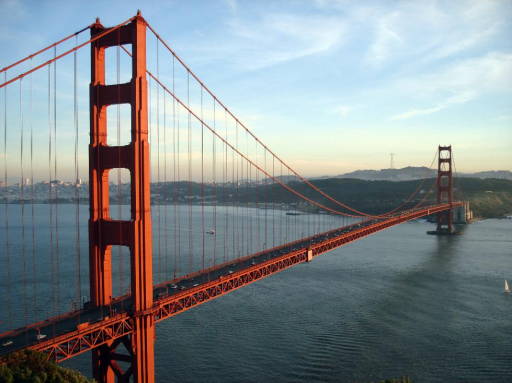

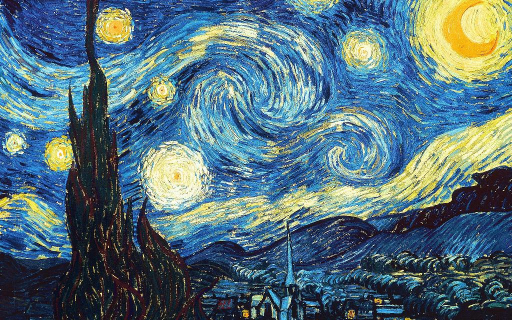

<optim.lbfgs> 	creating recyclable direction/step/history buffers	


<optim.lbfgs> 	reached max number of iterations	


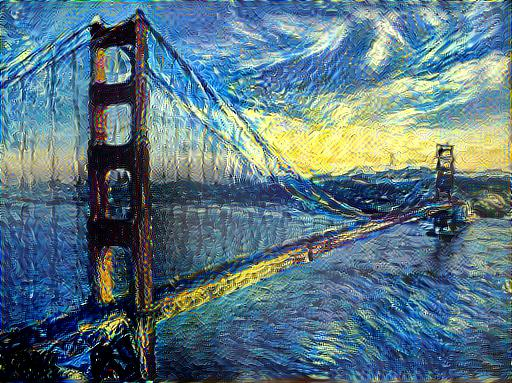

In [9]:
local content_path = "./images/golden_gate.jpg"
local style_path = "./images/starry_night.jpg"
local iterations = 1000

StyleTransfer(content_path, style_path, iterations, false)

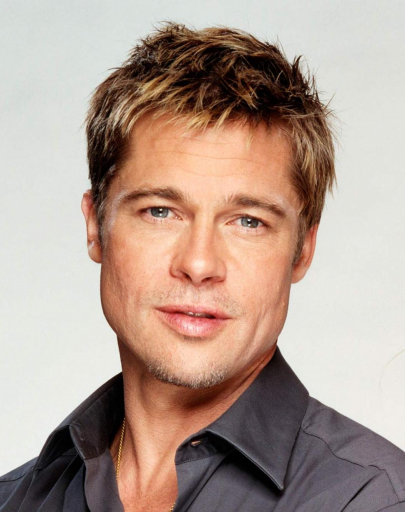

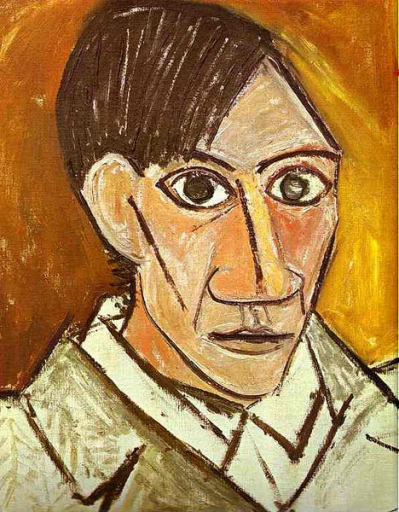

<optim.lbfgs> 	creating recyclable direction/step/history buffers	


<optim.lbfgs> 	reached max number of iterations	


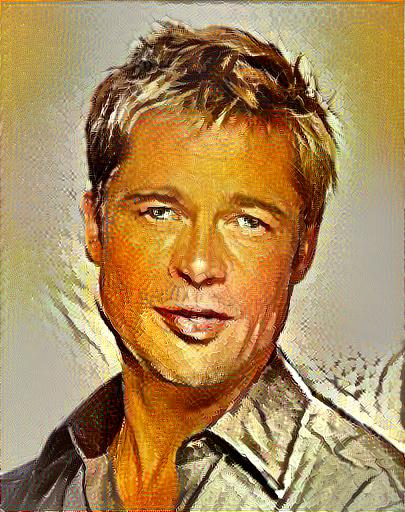

In [13]:
local content_path = "./images/brad_pitt.jpg"
local style_path = "./images/picasso_portrait.jpg"
local iterations = 1000

StyleTransfer(content_path, style_path, iterations, false)

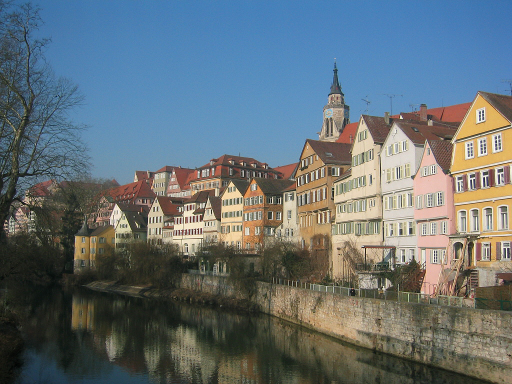

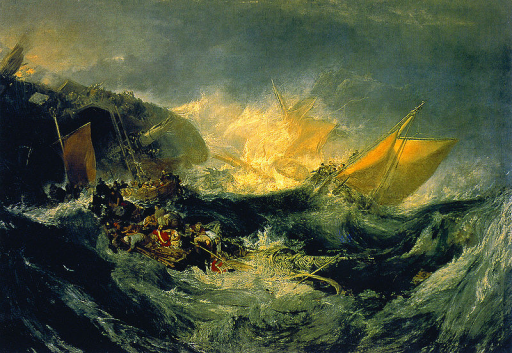

<optim.lbfgs> 	creating recyclable direction/step/history buffers	


<optim.lbfgs> 	reached max number of iterations	


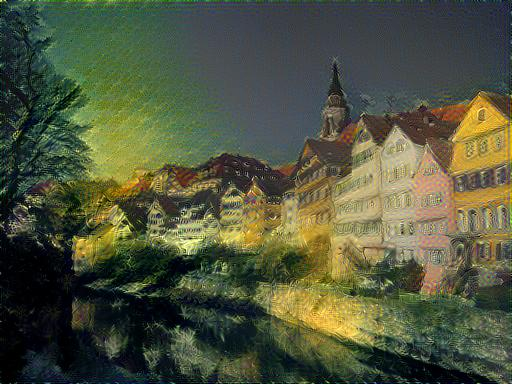

In [15]:
local content_path = "./images/RowHouse.jpg"
local style_path = "./images/the_shipwreck_of_the_minotaur.jpg"
local iterations = 1000

StyleTransfer(content_path, style_path, iterations, false)